**Problem statement**

Starbucks will like to know:

Customers to target for campaigns,
What campaigns to give to these segmented customers
To do this, I have segmented customers into income range,age range, offers received and explored data with visuals and checked which campaign offer type these segemented customers respond to more.



**Data Understanding:**

Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer

transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

***portfolio.json***

id (string) - offer id

offer_type (string) - type of offer ie BOGO, discount, informational

difficulty (int) - minimum required spend to complete an offer

reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days

channels (list of strings)

***profile.json***

age (int) - age of the customer

became_member_on (int) - date when customer created an app account

gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)

id (str) - customer id

income (float) - customer's income

***transcript.json***

event (str) - record description (ie transaction, offer received, offer viewed, etc.)

person (str) - customer id

time (int) - time in hours since start of test. The data begins at time t=0

value - (dict of strings) - either an offer id or transaction amount depending on the record

In [ ]:
from google.colab import files
uploaded = files.upload()

!unzip -q dataStarbucks.zip


Saving dataStarbucks.zip to dataStarbucks.zip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#orient 'records' : list like [{column -> value}]
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [ ]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [ ]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**Transcript clean up**

In [ ]:
transcript['key'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['amount'] = transcript['value'].apply(lambda x: list(x.values())[0])
transcript['offer_id'] = transcript['amount']

transcript['amount'] = np.where(transcript['key'] == 'offer id', np.NaN, transcript['amount'])
transcript['amount'] = np.where(transcript['key'] == 'offer_id', np.NaN, transcript['amount'])
transcript['offer_id'] = np.where(transcript['key'] == 'amount', np.NaN, transcript['offer_id'])

transcript['amount'].astype(np.float64)
transcript.drop(['value', 'key'], axis=1, inplace=True)
transcript.rename(columns={"person":"customer_ID"},inplace=True)


**Portfolio clean up**

In [ ]:
portfolio['duration']=portfolio['duration']*24
print(f"channels :{portfolio['offer_type'].unique()}")

channels :['bogo' 'informational' 'discount']


In [ ]:
available_channels=[]
for channel in portfolio['channels']:
  for ch in channel:
    if ch not in available_channels:
      available_channels.append(ch)


available_channels

['email', 'mobile', 'social', 'web']

In [ ]:
for channel in available_channels:
  portfolio[channel]=portfolio['channels'].apply(lambda x:1 if channel in x else 0)

In [ ]:
portfolio.drop(['channels'],axis=1,inplace=True)
portfolio.rename(columns={"id":"offer_Id"},inplace=True)

In [ ]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_Id,email,mobile,social,web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


**Profile clean up**

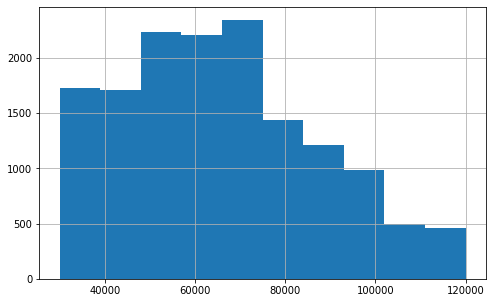

In [ ]:
profile['income'].hist(bins=10,figsize=(8,5))

In [ ]:
profile['income'].fillna(profile['income'].median(),inplace=True)
profile['gender'].fillna('U',inplace=True)
profile['became_member_on']=profile['became_member_on'].apply(lambda x:str(x))
profile['became_member_on']=pd.to_datetime(profile['became_member_on'])
profile.rename(columns={"id":"customer_ID"},inplace=True)

In [ ]:
dte=pd.to_datetime(profile['became_member_on'])
print(f"first date : {dte.min()} last date : {dte.max()}")

first date : 2013-07-29 00:00:00 last date : 2018-07-26 00:00:00


In [ ]:
 #Calculating number of days as a member ending on August 1, 2018 in new column 'days_as_member'
end_date = pd.Timestamp('2018-08-01')
end_date = pd.to_datetime(end_date)
profile['days_as_member'] = np.abs((pd.to_datetime(profile['became_member_on']) - end_date).dt.days)

In [ ]:
profile.drop(['became_member_on'],axis=1,inplace=True)

In [ ]:
# Merging Transcript and Profile
transcript_profile_df=pd.merge(transcript,profile,left_on=['customer_ID'],right_on=['customer_ID'],how='left')
#Merging Transcript and Profile and Portfolio
transcript_profile_portfolio_df=pd.merge(transcript_profile_df,portfolio,left_on=['offer_id'],right_on=['offer_Id'],how='left')

In [ ]:
#One hot encoding event values
event_dummies = pd.get_dummies(transcript_profile_df['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript_profile_df = pd.concat([transcript_profile_df, event_dummies], axis = 1)

In [ ]:
transcript_profile_portfolio_df.rename(columns={'amount':'transactional_amount'},inplace=True)
transcript_profile_portfolio_df

,customer_ID,event,time,transactional_amount,offer_id,gender,age,income,days_as_member,reward,difficulty,duration,offer_type,offer_Id,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,449,5.0,5.0,168.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,U,118,64000.0,362,5.0,20.0,240.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,70000.0,97,2.0,10.0,168.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,U,118,64000.0,310,2.0,10.0,240.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,U,118,64000.0,303,10.0,10.0,120.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,M,66,47000.0,212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,M,52,62000.0,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,F,63,52000.0,1774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,M,57,40000.0,753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
transcript_profile_portfolio_df['offer_type'].fillna('No_offer',inplace=True)

In [ ]:
#One hot encoding event values
event_dummies_onehot = pd.get_dummies(transcript_profile_portfolio_df['event'])
event_dummies_onehot.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript_profile_portfolio_df = pd.concat([transcript_profile_portfolio_df, event_dummies_onehot], axis = 1)

In [ ]:
offerType_dummies_onehot = pd.get_dummies(transcript_profile_portfolio_df['offer_type'],prefix='offer')
transcript_profile_portfolio_df = pd.concat([transcript_profile_portfolio_df, offerType_dummies_onehot], axis = 1)
transcript_profile_portfolio_df

,customer_ID,event,time,transactional_amount,offer_id,gender,age,income,days_as_member,reward,difficulty,duration,offer_type,offer_Id,email,mobile,social,web,offer_completed,offer_received,offer_viewed,transaction,offer_No_offer,offer_bogo,offer_discount,offer_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,449,5.0,5.0,168.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,0,1,0,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,U,118,64000.0,362,5.0,20.0,240.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0,0,1,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,M,68,70000.0,97,2.0,10.0,168.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0,1,0,0,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,U,118,64000.0,310,2.0,10.0,240.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0,1,0,0,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,U,118,64000.0,303,10.0,10.0,120.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,M,66,47000.0,212,NaN,NaN,NaN,No_offer,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1,0,0,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,M,52,62000.0,115,NaN,NaN,NaN,No_offer,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1,0,0,0
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,F,63,52000.0,1774,NaN,NaN,NaN,No_offer,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1,0,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,M,57,40000.0,753,NaN,NaN,NaN,No_offer,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1,0,0,0


In [ ]:
# w=transcript_profile_portfolio_df['customer_ID'].unique() 
# df=pd.DataFrame({'CustId':w})
# Offer=['bogo','discount','informational']
# q=[]
  
# for cus in df['CustId']:
#     cu=cus
#     for ca in Offer:
#         n=transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID']==cus]['offer_type'].map(lambda d: ca in d).sum()
#         en={'id':cus,'cate':ca,'count':n}
#         q.append(en)
# q=pd.DataFrame(q)
# q
       

In [ ]:
unique_custids=transcript_profile_portfolio_df['customer_ID'].unique() 
df=pd.DataFrame({'CustId':unique_custids})
Offer=['bogo','discount','informational']
modified_data=[]

  
for cus in df['CustId']:
    cu=cus
    total_offers_viewed = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['offer_viewed'].sum()
    total_offers_received = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['offer_received'].sum()
    total_offers_completed = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['offer_completed'].sum()
    Avg_transaction_amnt=transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['transactional_amount'].mean()
    total_Rewarded = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['reward'].sum()
    Age = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['age'].values[0]
    Gender = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['gender'].values[0]
    Income = transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['income'].values[0]
    lastb= transcript_profile_portfolio_df[transcript_profile_portfolio_df['customer_ID'] == cus]['time'].diff()
    if lastb.values[-1]==0:
      lastdaysFrom_purchase=(lastb.values[-2]/24)
    else:
      lastdaysFrom_purchase=(lastb.values[-1]/24)
    for ca in Offer:
        df1= transcript_profile_portfolio_df[(transcript_profile_portfolio_df['customer_ID'] == cus)
                       & (transcript_profile_portfolio_df['offer_type'] == ca)]
        
        if ca=='bogo': 
          of_comp_bg=df1['offer_completed'].sum()
          of_recd_bg=df1['offer_received'].sum()
          of_viewed_bg=df1['offer_viewed'].sum()
          of_net_bg_reward=df1['reward'].mean()
          avg_duration_bogo = df1['duration'].mean()
          avg_difficulty_bogo = df1['difficulty'].mean()
          
          
        elif ca=='discount':
          of_comp_dis=df1['offer_completed'].sum()
          of_recd_dis=df1['offer_received'].sum()
          of_viewed_dis=df1['offer_viewed'].sum()
          of_net_dis_reward=df1['reward'].mean()
          avg_duration_dis = df1['duration'].mean()
          avg_difficulty_dis = df1['difficulty'].mean()

        elif ca=='informational':
          of_recd_inf=df1['offer_received'].sum()
          of_viewed_inf=df1['offer_viewed'].sum()
          
          

    attributes={'customerId':cus,
        'age':Age,
        'gender':Gender,
        'income':Income,
        'bogo_offer_completed': of_comp_bg,
        'bogo_offer_received':of_recd_bg,
        'bogo_offer_viewed':of_viewed_bg,
        'bogo_net_reward':of_net_bg_reward,
        'discount_offer_completed':of_comp_dis,
        'discount_offer_received':of_recd_dis,
        'discount_offer_viewed':of_viewed_dis,
        'discount_net_reward':of_net_dis_reward,
        'informational_offer_received':of_recd_inf,
        'informational_offer_viewed':of_viewed_inf,
        'total_offer_completed':total_offers_completed,
        'total_offer_viewed':total_offers_viewed,
        'total_offer_received':total_offers_received,
        'total_rewards':total_Rewarded,
        'Average_transaction_amount':Avg_transaction_amnt,
        'DaysFromLastPurchase':lastdaysFrom_purchase,
        'Average_bogo_duration':avg_duration_bogo,
        'Average_bogo_difficulty':avg_difficulty_bogo,
        'Average_discount_duration':avg_duration_dis,
        'Average_discount_difficulty':avg_difficulty_dis
        }
    modified_data.append(attributes)
modified_data=pd.DataFrame(modified_data)
modified_data
    

# df1=transcript_profile_portfolio_df[(transcript_profile_portfolio_df['customer_ID'] == '78afa995795e4d85b5d9ceeca43f5fef')
#                        & (transcript_profile_portfolio_df['offer_type'] == 'bogo')]
# cus='78afa995795e4d85b5d9ceeca43f5fef'
# n=df1['offer_completed'].sum()
# if ca=='bogo'
# print(f"cus:{cus},sum:{n}")
#correct





,customerId,age,gender,income,bogo_offer_completed,bogo_offer_received,bogo_offer_viewed,bogo_net_reward,discount_offer_completed,discount_offer_received,discount_offer_viewed,discount_net_reward,informational_offer_received,informational_offer_viewed,total_offer_completed,total_offer_viewed,total_offer_received,total_rewards,Average_transaction_amount,DaysFromLastPurchase,Average_bogo_duration,Average_bogo_difficulty,Average_discount_duration,Average_discount_difficulty
0,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,3,3,3,6.666667,0,0,0,NaN,1,1,3,4,4,60.0,22.752857,2.00,152.0,6.666667,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,118,U,64000.0,0,0,0,NaN,0,3,2,5.0,2,1,0,3,5,25.0,1.550000,0.50,NaN,NaN,240.0,20.0
2,e2127556f4f64592b11af22de27a7932,68,M,70000.0,1,1,1,5.000000,1,2,2,2.0,1,0,2,3,4,25.0,19.243333,0.00,168.0,5.000000,211.2,10.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,118,U,64000.0,0,1,1,10.000000,0,3,3,2.0,1,1,0,5,5,32.0,NaN,0.75,120.0,10.000000,216.0,10.0
4,68617ca6246f4fbc85e91a2a49552598,118,U,64000.0,0,3,2,8.000000,0,2,2,2.5,0,0,0,4,5,50.0,0.120000,0.25,148.8,8.000000,168.0,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,9fcbff4f8d7241faa4ab8a9d19c8a812,47,M,94000.0,0,1,1,10.000000,0,0,0,NaN,1,1,0,2,2,20.0,NaN,3.00,120.0,10.000000,NaN,NaN
16996,ebae5093b436466c9fbd097cb7434023,118,U,64000.0,0,0,0,NaN,1,1,1,2.0,0,0,1,1,1,6.0,7.605000,3.00,NaN,NaN,240.0,10.0
16997,912b9f623b9e4b4eb99b6dc919f09a93,118,U,64000.0,0,1,1,10.000000,0,0,0,NaN,0,0,0,1,1,20.0,NaN,0.75,120.0,10.000000,NaN,NaN
16998,3045af4e98794a04a5542d3eac939b1f,58,F,78000.0,0,1,1,10.000000,0,0,0,NaN,0,0,0,1,1,20.0,NaN,NaN,120.0,10.000000,NaN,NaN


In [ ]:
modified_data.to_csv('Starbucks_Transformed_Data.csv') 

In [ ]:
 transcript_profile_portfolio_df.columns

Index(['customer_ID', 'event', 'time', 'transactional_amount', 'offer_id',
       'gender', 'age', 'income', 'days_as_member', 'reward', 'difficulty',
       'duration', 'offer_type', 'offer_Id', 'email', 'mobile', 'social',
       'web', 'offer_completed', 'offer_received', 'offer_viewed',
       'transaction', 'offer_No_offer', 'offer_bogo', 'offer_discount',
       'offer_informational'],
      dtype='object')